# NN with only Convolution Layers + LSTM for 3 Track Events (find track parameters)

In [11]:

# System imports
import math
from __future__ import print_function

# Standard imports
import sys
import numpy as np
from tempfile import TemporaryFile

# Python Externa Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Keras Imports
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2


# Local imports
from local_modules import generate_data, track_hit_coords, drawMulti_from_params_pix, drawMulti_from_params, get_Alist_pulls

# Magic
%matplotlib inline

In [12]:
data = np.load('/bigdata/atsaris/new/data6trk_256.npz')

In [13]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, num_det_layers, det_layer_size, det_layer_size))
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling3D(pool_size=(2,2,2))(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(4))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal", metrics=['accuracy'])
    return model

In [14]:
# Configuration
num_det_layers = data['num_det_layers']
det_layer_size = data['det_layer_size']
num_seed_layers = 0
avg_bkg_tracks = 0
noise_prob = 0.0
det_shape = (num_det_layers, det_layer_size, det_layer_size)

max_tracks = data['max_tracks']
num_tracks = data['num_tracks']

# Training parameters
batch_size = data['batch_size']
epoch_size = data['epoch_size']
num_epochs = data['num_epochs']


print(max_tracks, num_tracks, batch_size, epoch_size, num_epochs)

6 3 256 25600 10


In [15]:
# Train the model
model_2 = build_model_2()
history = model_2.fit(data['events'], data['target_slope'], batch_size=batch_size, nb_epoch=num_epochs, 
           validation_split=0.1, sample_weight=data['weights'])

Train on 23040 samples, validate on 2560 samples
Epoch 1/10
23040/23040 [==============================] - 23s - loss: 51.5099 - acc: 0.3465 - val_loss: 45.3829 - val_acc: 0.3681
Epoch 2/10
23040/23040 [==============================] - 23s - loss: 43.7750 - acc: 0.3679 - val_loss: 42.5747 - val_acc: 0.3710
Epoch 3/10
23040/23040 [==============================] - 23s - loss: 41.0558 - acc: 0.3726 - val_loss: 39.9347 - val_acc: 0.3765
Epoch 4/10
23040/23040 [==============================] - 23s - loss: 38.3197 - acc: 0.3756 - val_loss: 37.2688 - val_acc: 0.3753
Epoch 5/10
23040/23040 [==============================] - 23s - loss: 35.8681 - acc: 0.3768 - val_loss: 34.1749 - val_acc: 0.3794
Epoch 6/10
23040/23040 [==============================] - 23s - loss: 31.1714 - acc: 0.3789 - val_loss: 28.6547 - val_acc: 0.3798
Epoch 7/10
23040/23040 [==============================] - 23s - loss: 26.5673 - acc: 0.3807 - val_loss: 24.0760 - val_acc: 0.3822
Epoch 8/10
23040/23040 [=================

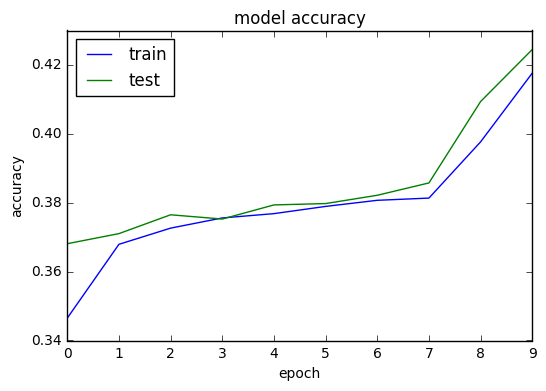

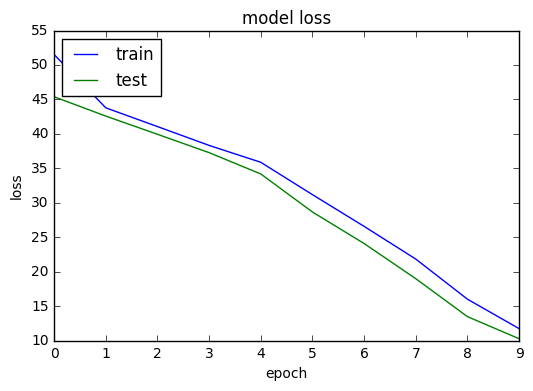

In [16]:
# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
#test_data = np.load('/home/atsaris/hepTrack_newY_test/23_04_2017/test_data.npz')
test_data = np.load('/bigdata/atsaris/new/test6trk_256.npz')
train_events = test_data['events']
train_targets_slope = test_data['target_slope']
train_targets_slope_pix = test_data['target_slope_pix']
train_weights = test_data['weights']

In [18]:
#test_index = np.random.randint(0,test_data['epoch_size'])
test_index = np.random.randint(0,1000)
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
test_a = train_targets_slope_pix[test_index][test_weights]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]

In [19]:
for i in range(0, 4):
    mu, sigma = get_Alist_pulls(model_2, 1000, train_events, train_weights, train_targets_slope, i, False)
    if(i<4): print("target: ", mu, sigma)
    else: print("pixel: ", mu, sigma)

target:  0.0373190902818 0.533765017095
target:  -0.0489845405756 1.08734324771
target:  -0.185970043 3.77609956698
target:  -0.0650823451155 4.93331724075


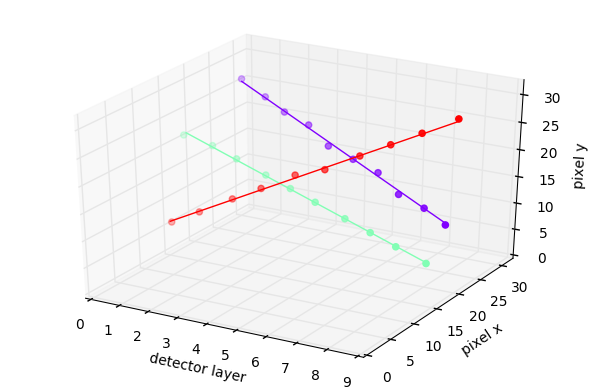

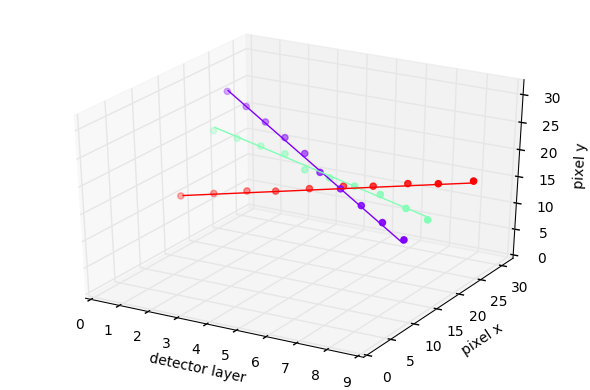

In [20]:
test_index = np.random.randint(0,test_data['epoch_size'])
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
#test_a = train_targets_slope_pix[test_index][test_weights]
test_a = train_targets_slope[test_index][test_weights]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
drawMulti_from_params_pix(num_tracks, test_a, num_det_layers, det_layer_size, True)
drawMulti_from_params_pix(num_tracks, test_pred, num_det_layers, det_layer_size, True)